In [1]:
# From https://github.com/luphord/longstaff_schwartz/blob/master/talks/talk_pyconde_2019-10-10/Notebook_PyConDE_2019-10-10.ipynb

In [2]:
import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

In [3]:
class GeometricBrownianMotion:
    '''Geometric Brownian Motion
    
    This is copied from the stochastic_process.py file included in the longstaff_schwartz.py package. I strongly 
    recommend you install the package and understand how it works:
    
    pip install longstaff-schwartz
    
    This is a simple class that allows simulating the GBM that we have used all semester long within the BMS framework.  
    '''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)
        return np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T

    def distribution(self, t: float) -> rv_frozen:
        mu_t = (self.mu - self.sigma**2/2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)

In [4]:
svg_out_path = None # Path('img')

if svg_out_path:
    svg_out_path.mkdir(parents=True, exist_ok=True)

# Switch to false to see richer simulations once you understand what's going on in the simple example
LS_EXAMPLE = False
    
if LS_EXAMPLE: 
    # This is the data as pulled from the example in the introdution of Longstaff & Schwartz (2001, RFS, 
    # referred to as LS hereafter) 
    t = np.linspace(0, 3, 4)
    r = 0.06
    X = np.array([
            [1.00, 1.09, 1.08, 1.34],
            [1.00, 1.16, 1.26, 1.54],
            [1.00, 1.22, 1.07, 1.03],
            [1.00, 0.93, 0.97, 0.92],
            [1.00, 1.11, 1.56, 1.52],
            [1.00, 0.76, 0.77, 0.90],
            [1.00, 0.92, 0.84, 1.01],
            [1.00, 0.88, 1.22, 1.34]]).T
    S0 = 1.00
    strike = 1.10
    
else:    
    S0 = 680
    strike = S0
    sigma = 0.2
    # zero interest rate so that we can ignore discounting
    gbm = GeometricBrownianMotion(mu=0.0, sigma=sigma)
    t = np.linspace(0, 5, 12*5)
    rnd = RandomState(seed=1234)
    X = S0 * gbm.simulate(t, 50, rnd)

rf = 0.06
df = lambda t_from, t_to: np.exp(-rf * (t_to - t_from))
X.shape

(60, 50)

In [5]:
figsize = (8, 6)

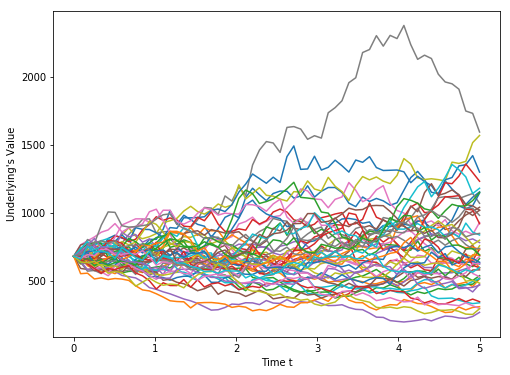

In [6]:
plt.figure(figsize=figsize)
plt.plot(t, X);
plt.xlabel('Time t')
plt.ylabel("Underlying's Value")

if svg_out_path:
    plt.savefig(svg_out_path / 'monte-carlo.svg', transparent=True)

In [7]:
# The above figure essentially provide a graphical representation of the first table on page 116 of LS 

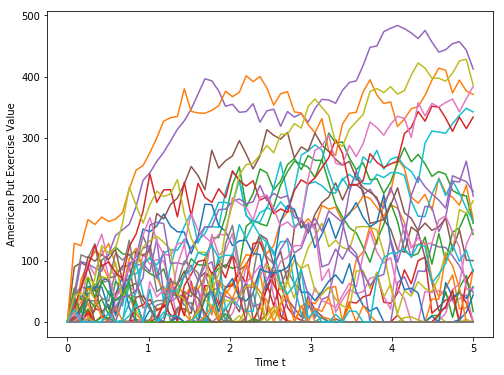

In [8]:
plt.figure(figsize=figsize)
plt.plot(t, np.maximum(strike - X, 0));
plt.xlabel('Time t')
plt.ylabel('American Put Exercise Value')

if svg_out_path:
    plt.savefig(svg_out_path / 'exercise-value.svg', transparent=True)

In [9]:
# In the above, the time 3 values provide a graphical representation of the last column of the second table on page 116 of LS

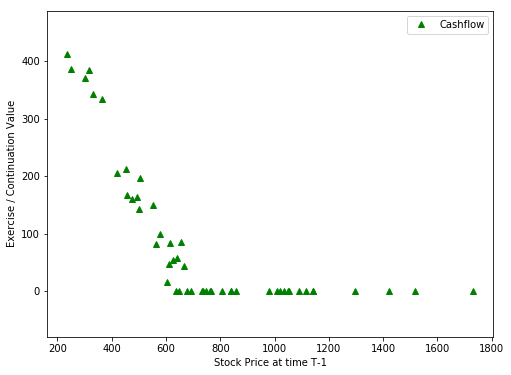

In [10]:
# Now, let's graph the cashflows at time 3, as a function of the stock price at time 2  
cashflow = np.maximum(strike - X[-1, :], 0)
plt.figure(figsize=figsize)
plt.plot(X[-2, :], cashflow, 'g^', zorder=3);
plt.legend(['Cashflow'])
plt.xlabel('Stock Price at time T-1')
plt.ylabel('Exercise / Continuation Value')

if LS_EXAMPLE:
    YL = (-0.03, 0.23)
else:
    YL = (-79.08911992730148, 488.124954950677)
plt.ylim(YL)

if svg_out_path:
    plt.savefig(svg_out_path / 'continuation-value-cashflows.svg', transparent=True)

In [11]:
# And let's first fit a quadratic polynomial, *naively*, to represent the relationship
p0 = Polynomial.fit(X[-2, :], cashflow, 2)
p0

Polynomial([ -38.49025321, -129.88785796,  284.57283595], domain=[ 236.50457879, 1731.84287448], window=[-1.,  1.])

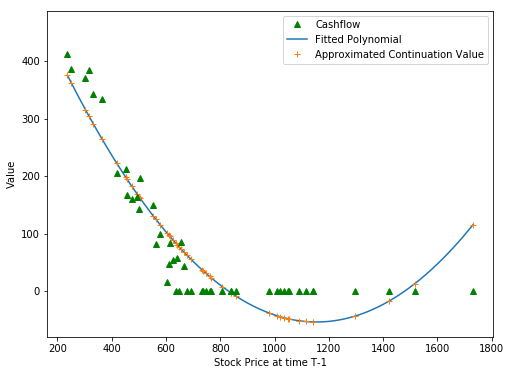

In [12]:
plt.figure(figsize=figsize)
plt.plot(X[-2, :], cashflow, 'g^', zorder=3);
plt.plot(*p0.linspace(), zorder=1);
plt.plot(X[-2, :], p0(X[-2, :]), '+', zorder=2);
plt.legend(['Cashflow',
            'Fitted Polynomial',
            'Approximated Continuation Value'])
plt.xlabel('Stock Price at time T-1')
plt.ylabel('Value')
plt.ylim(YL)

if svg_out_path:
    plt.savefig(svg_out_path / 'continuation-value-approximation.svg', transparent=True)

In [13]:
# When estimating the above polynomial, we neglect 2 important things:
#   (i)  if the option is currently OTM, you wouldn't consider exercising it 
#   (ii) the cashflow is a *future* cashflow, it must be discounted   
itm = strike > X[-2, :]
x = X[-2, itm].reshape(-1,1)
y = df(2,3)*cashflow[itm].reshape(-1,1)
yx = np.array((y, x)).T
print('[ Y  X ] =\n', yx, '\n')
p = Polynomial.fit(X[-2, itm], df(2,3)*cashflow[itm], 2)
print('Polynomial:', p, '\n')

# For direct comparison with what is reported in LS, here is the "linear regression" approach
from sklearn import linear_model
#regr = linear_model.LinearRegression(fit_intercept=False)
#regr.fit(np.concatenate((np.ones(y.shape), x, x*x),axis=1), y)
#print(regr.coef_)
xx = np.concatenate((x, x*x),axis=1)
regr = linear_model.LinearRegression()
regr.fit(xx, y)
print('As reported in LS:',regr.intercept_, regr.coef_, '\n')

# Both approaches yield the same results (Polynomial runs a least square fit...)
print('Difference:\n',regr.predict(xx) - p(x), '\n')

[ Y  X ] =
 [[[157.35588684 456.6455882 ]
  [151.52375035 474.47836158]
  [  0.         648.89534532]
  [ 44.9671205  610.86952912]
  [154.84184759 494.48617843]
  [ 80.49383918 657.0184106 ]
  [134.37006713 501.70763135]
  [193.33388578 417.55453414]
  [  1.05127585 635.2988126 ]
  [  0.         675.96389747]
  [322.7313553  331.45196266]
  [ 15.90105951 603.95658399]
  [388.62640659 236.50457879]
  [142.09958837 553.62031644]
  [186.24421628 503.19470005]
  [ 54.06268922 641.57514556]
  [349.63104154 303.25132615]
  [ 79.92757326 613.45346825]
  [ 94.31512026 579.27611273]
  [ 51.21801341 626.52439372]
  [ 41.50670028 664.72934193]
  [314.79377306 364.59697719]
  [200.30409935 451.16660001]
  [361.86476025 315.73132809]
  [363.98969392 251.52785885]
  [ 77.16095553 562.71492645]]] 

Polynomial: poly([ 190.08901274 -198.30043417   18.55432565]) 

As reported in LS: [681.82026746] [[-1.25313415e+00  3.84297722e-04]] 

Difference:
 [[ 8.52651283e-14]
 [ 0.00000000e+00]
 [ 8.52651283e-14

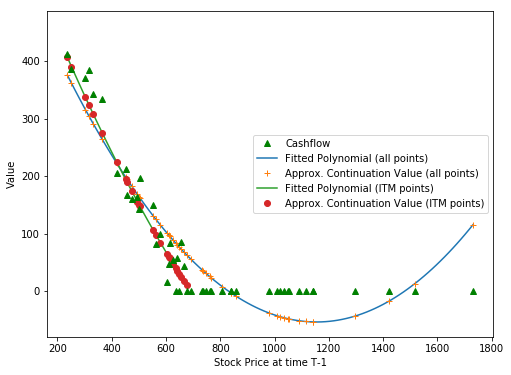

In [14]:
# Let's repeat the figure above with the approximation suggested in LS
plt.figure(figsize=figsize)
plt.plot(X[-2, :], cashflow, 'g^', zorder=3);
plt.plot(*p0.linspace(), zorder=1);
plt.plot(X[-2, :], p0(X[-2, :]), '+', zorder=2);

plt.plot(*p.linspace(), zorder=1);
plt.plot(X[-2, itm], p(X[-2, itm]), 'o', zorder=2);
plt.legend(['Cashflow',
            'Fitted Polynomial (all points)',
            'Approx. Continuation Value (all points)',
            'Fitted Polynomial (ITM points)',
            'Approx. Continuation Value (ITM points)'],loc=5)
plt.xlabel('Stock Price at time T-1')
plt.ylabel('Value')
plt.ylim(YL)

if svg_out_path:
    plt.savefig(svg_out_path / 'continuation-value-approximation.svg', transparent=True)

In [15]:
# In the LS_EXAMPLE, with only 5 ITM points, it isn't clear that the ITM approximation is more accurate. 
# Actually, the concavity of the estimated polynomial is clearly problematic here... 
# But with more points, this issue not only vanishes, but the fit to the relevant cash flows is much better.

In [16]:
# The code in this cell essentially reproduces the longstaff_schwartz_iter function, defined in longstaff_schwartz.algorithm

# Let's store the intermediate results...
intermediate_results = []

# given no prior exercise we just receive the payoff of a European option
cashflow = np.maximum(strike - X[-1, :], 0.0)
# iterating backwards in time 
for i in reversed(range(1, X.shape[0] - 1)):
    # discount cashflows from next period
    cashflow = cashflow * df(t[i], t[i+1])
    # get current state    
    x = X[i, :]
    # exercise value for time t[i]
    exercise = np.maximum(strike - x, 0.0)
    # boolean index of all in-the-money paths
    itm = exercise > 0.0
    # fit polynomial of degree 2
    fitted = Polynomial.fit(x[itm], cashflow[itm], 2)
    # approximate continuation value
    continuation = fitted(x)
    
    # Update cashflows with early exercises: Note that the *approximate* continuation value is used 
    # ONLY to take the decision. At time T-1, for instance, on the trajectories where the put is not exercised, 
    # the cashflow vector simply keeps the time T payoff, which was discounted entering this loop, 
    # and will be discounted again before analyzing T-2, and so on and so forth. Vs footnote 9 in LS: "For example, 
    # if the American option were valued by taking the maxinium of the immediate exercise value and the estimated 
    # continuation value, and discounting this value back, the resulting American option value could be severely 
    # upward biased. This bias arises since the maximum operator is convex; measurement error in the estimated 
    # continuation value results in the maximum operator being upward biased. We are indebted to Peter Bossaerts 
    # for making this point."
    ex_idx = itm & (exercise > continuation)
    cashflow[ex_idx] = exercise[ex_idx]
    
    intermediate_results.append((cashflow.copy(), x, fitted, continuation, exercise, ex_idx))

In [17]:
# The next few cells simply contains the necessary stuff to get us to the next graph... See the note below it.

In [18]:
# Helper function to computed extremums through a sequence of arrays
def running_min_max(*array_seq):
    minimum, maximum = None, None
    for a in array_seq:
        cmin, cmax = a.min(), a.max()
        if minimum is None or cmin < minimum:
            minimum = cmin
        if maximum is None or cmax < maximum:
            maximum = cmax
    return minimum, maximum

In [19]:
grey = '#dddddd'

def plot_approx_n(n_steps, ax):
    cashflow, x, fitted, continuation, exercise, ex_idx = intermediate_results[n_steps]
    fitted_x, fitted_y = fitted.linspace()
    y_min, y_max = running_min_max(cashflow, exercise, fitted_y)
    offset = 0.1 * (y_max - y_min)
    ax.set_ylim((y_min - offset, y_max + offset))
    ax.plot(x, cashflow, '^', color='green', zorder=3);
    ax.plot(x[ex_idx], exercise[ex_idx], 'x', color='red', zorder=5);
    ax.plot(x[~ex_idx], exercise[~ex_idx], 'x', color=grey, zorder=4);
    ax.plot(fitted_x, fitted_y, zorder=2);
    _x = np.linspace(np.min(x), np.max(x))
    ax.plot(_x, fitted(_x), '--', color=grey, zorder=1);
    ax.legend(['Cashflow',
               'Favourable Exercise',
               'Unfavourable Exercise',
               'Approx. of Continuation Value',
               'Out-of-the-money Continuation Value'])

In [20]:
@interact(n_steps=IntSlider(min=0, max=len(intermediate_results)-1, value=0))
def step(n_steps):
    fig, ax = plt.subplots()
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    plot_approx_n(n_steps, ax)
    plt.xlabel('Coin Value')
    plt.ylabel('Exercise / Continuation Value')


interactive(children=(IntSlider(value=0, description='n_steps', max=57), Output()), _dom_classes=('widget-inte…

In [21]:
# At step 0, this graph is essentially the same as the previous one (declutered), which we had built, manually. 
# Slide the number of steps to see how the algo evolves as we get n_steps away from maturity

In [22]:
# From this point and on, the cells make little sense in the LS_EXAMPLE. 
# Set LS_EXAMPLE=False above and, in the Kernel menu, Restart and Run All

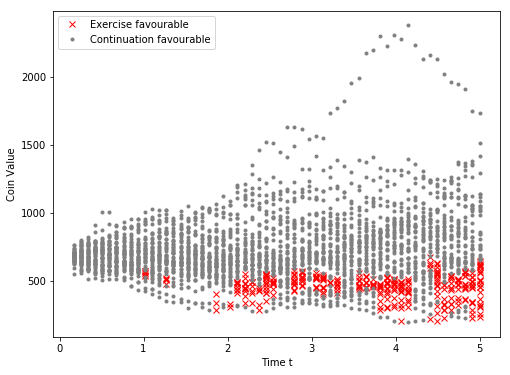

In [23]:
# We can retreive the exercise times and present them graphically...
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i-1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i-1])
        non_exercises.append(ex)

plt.figure(figsize=figsize)
plt.plot(exercise_times, exercises, 'rx');
plt.plot(non_exercise_times, non_exercises, '.', color='grey');
plt.legend(['Exercise favourable', 'Continuation favourable'])
plt.xlabel('Time t')
plt.ylabel('Coin Value')

if svg_out_path:
    plt.savefig(svg_out_path / 'exercise-or-hold.svg', transparent=True)

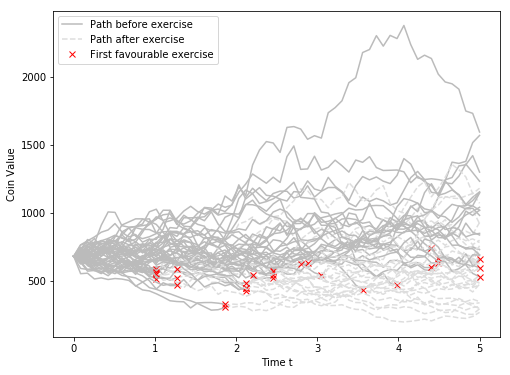

In [24]:
# As the algorithm runs backward, on a given trajectory, you could exercise at time t 
# and then "exercise again" at time s < t. Of course, as the option holder, what really 
# matters is the first time you exercise on a given trajectory: after having exercised, 
# you don't hold the option anymore
n_timesteps, n_paths = X.shape
first_exercise_idx = n_timesteps * np.ones(shape=(n_paths,), dtype='int')
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        idx_now = (n_timesteps - i - 1) * np.ones(shape=(n_paths,), dtype='int')
        first_exercise_idx[ex_idx] = idx_now[ex_idx]

plt.figure(figsize=figsize)
for i in range(n_paths):
    handle_path, = plt.plot(t[0:first_exercise_idx[i]+1], X[0:first_exercise_idx[i]+1, i], '-', color='#bbbbbb');
    handle_stopped_path, = plt.plot(t[first_exercise_idx[i]:], X[first_exercise_idx[i]:, i], '--', color=grey);
    if first_exercise_idx[i] < n_timesteps:
        handle_first_ex, = plt.plot(t[first_exercise_idx[i]], X[first_exercise_idx[i], i], 'rx');

plt.legend([handle_path, handle_stopped_path, handle_first_ex],
           ['Path before exercise', 'Path after exercise', 'First favourable exercise'])
plt.xlabel('Time t')
plt.ylabel('Coin Value')

if svg_out_path:
    plt.savefig(svg_out_path / 'first-exercises.svg', transparent=True)

Polynomial([ 375.7276507 ,  -41.63558334, -131.79219124], domain=[0.16949153, 5.        ], window=[-1.,  1.])

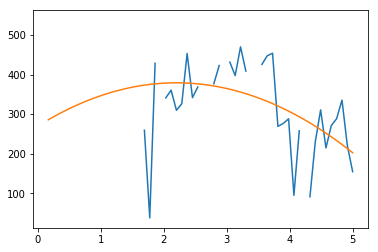

In [25]:
# But the "redundant" exercises 2 cells above can be useful to approximate the exercise boundary within the LS simulation 
ex_times = []
ex_boundary = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    fitted = fitted.convert(domain=[-1, 1], window=[-1, 1])
    to_solve = fitted - Polynomial([strike, -1])
    roots = to_solve.roots()
    roots = [root for root in roots if root <= strike and root >= 0 and root.imag == 0.0]
    if roots:
        ex_boundary.append(min(roots))
    else:
        ex_boundary.append(None)
    ex_times.append(t[-i-1])

ex_boundary = np.array(ex_boundary, dtype='float')
ex_times = np.array(ex_times)
fitted_boundary = Polynomial.fit(ex_times[~np.isnan(ex_boundary)], ex_boundary[~np.isnan(ex_boundary)], 2)
plt.plot(ex_times, ex_boundary);
plt.plot(*fitted_boundary.linspace());
fitted_boundary

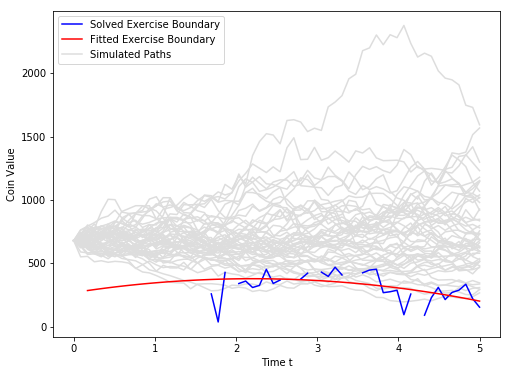

In [26]:
plt.figure(figsize=figsize)
plt.plot(ex_times, ex_boundary, color='blue', zorder=2)
plt.plot(*fitted_boundary.linspace(), 'r', zorder=3)
plt.plot(t, X, color='#dddddd', zorder=1)
plt.legend(['Solved Exercise Boundary',
            'Fitted Exercise Boundary',
            'Simulated Paths']);
plt.xlabel('Time t')
plt.ylabel('Coin Value')

if svg_out_path:
    plt.savefig(svg_out_path / 'fitted-exercise-boundary.svg', transparent=True)

In [ ]:
# Unfortunately, the "original" boundary is irregular, and even the smoother boundary is incompatible with what we
# have seen in the binomial tree. Compare with the graph below.

In [27]:
from longstaff_schwartz.binomial import create_binomial_model, american_put_price, american_put_exercise_barrier_fitted

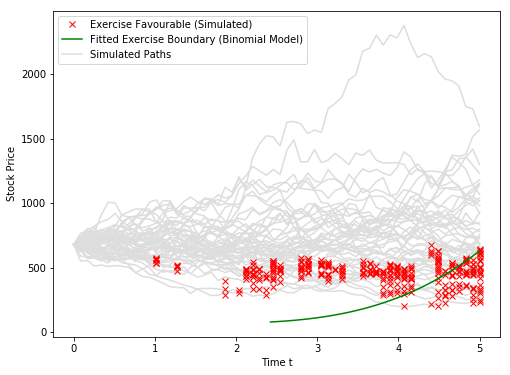

In [28]:
mdl = create_binomial_model(sigma=sigma, r=1e-14, S0=S0, T=5, n=100)
exercise_barrier = american_put_exercise_barrier_fitted(mdl, strike, 3)

plt.figure(figsize=figsize)
plt.plot(exercise_times, exercises, 'rx', zorder=2)
plt.plot(*exercise_barrier.linspace(), 'g', zorder=3)
plt.plot(t, X, color='#dddddd', zorder=1)
plt.legend(['Exercise Favourable (Simulated)',
            'Fitted Exercise Boundary (Binomial Model)',
            'Simulated Paths']);
plt.xlabel('Time t')
plt.ylabel('Stock Price')

if svg_out_path:
    plt.savefig(svg_out_path / 'binomial-fitted-exercise-boundary.svg', transparent=True)

In [ ]:
# As is illustrated here, the biggest weakness of the LS algorithm, is its very(!) approximative description of the 
# exercise boundary. Here, for instance, we see a substantial amount of suboptimal early exercise. On the other hand,
# the strength of the LS algo is that it applies under much more general setups than the GBM; setups for which trees 
# would be difficult, if not impossible to design. Many papers present improvements of the LS algo given our discussion above.

In [29]:
european_cashflow = np.maximum(strike - X[-1, :], 0)

In [30]:
assert np.average(cashflow) >= np.average(european_cashflow)
print(np.round(np.average(cashflow), 4))
print(np.round(np.average(european_cashflow), 4))

92.9582
84.1466
